In [27]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray
import rasterio
import matplotlib.pyplot as plt
import pyproj
import warnings

from functools import partial
from shapely.ops import transform
from keplergl import KeplerGl
from shapely.geometry import mapping
from shapely.wkt import loads
from rasterio import plot

import sys
sys.path.insert(1, '../config/')
import kepler_configs

import pycrs


%matplotlib inline
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

## testing 

In [2]:
tiff_path = '../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_30_lon_70_general-v1.5.tif'
rds = rioxarray.open_rasterio(tiff_path, parse_coordinates=True)


In [9]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))

In [11]:
poly = districts_gpd[districts_gpd.DISTRICT.isin(['LAHORE'])].geometry.values[0]
geom = mapping(loads(str(poly)))

In [20]:
districts_gpd[districts_gpd.DISTRICT.isin(['LAHORE'])]

,OBJECTID,PROVINCE,DISTRICT,Shape_Leng,ADMIN_UNIT,Shape_Le_1,Shape_Le_2,Shape_Area,geometry
100,104,PUNJAB,LAHORE,2.492281,DISTRICT,2.446038,2.446038,0.159835,"POLYGON ((74.49830 31.70571, 74.49919 31.70309..."


In [34]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [ ]:
tiff_path = '../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_30_lon_70_general-v1.5.tif'
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'
out_tiff = 'temp.tiff'
districts_gpd = gpd.read_file(district_shp_path)
req_rasterio = rasterio.open(tiff_path)

In [35]:
coords = getFeatures(districts_gpd[districts_gpd.DISTRICT.isin(['LAHORE'])])

In [36]:
out_img, out_transform = rasterio.mask.mask(dataset=req_rasterio, shapes=coords, crop=True)
out_meta = req_rasterio.meta.copy()
epsg_code = int(req_rasterio.crs.data['init'][5:])
out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2],
                 "transform": out_transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

with rasterio.open(out_tiff, "w", **out_meta) as dest:
    dest.write(out_img)

In [45]:
lahore_pop_temp = rasterio.open('temp.tiff')

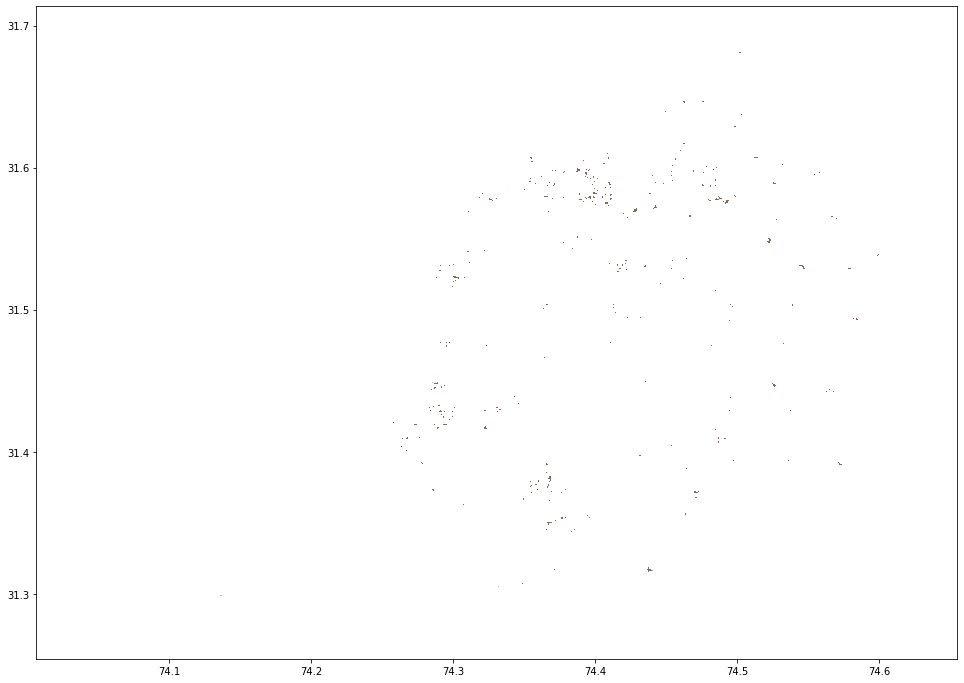

<AxesSubplot:>

In [48]:
fig = plt.figure(figsize=(18,12))
rasterio.plot.show(lahore_pop_temp,cmap='terrain')


In [4]:
#lahore_pop_fb = rds.rio.clip([geom],'EPSG:4326',drop=True)


In [ ]:
lahore_pop_fb.rio.to_raster('../data/raster/lahore_masked_pop_fb.tiff')

In [ ]:
lahore_pop_fb = rasterio.open('../data/raster/lahore_masked_pop_fb.tiff')

In [ ]:
fig = plt.figure(figsize=(18,12))
plot.show(lahore_pop_fb)


## formalize clipping code
#### IT WORKS!

In [2]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [3]:
def flip(x, y):
    """Flips the x and y coordinate values"""
    return y, x

In [4]:
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'
out_tiff = 'temp.tiff'
districts_gpd = gpd.read_file(district_shp_path)


In [5]:
## tiff selector
district_name = 'LAHORE' # add district name here
select_df = pd.DataFrame(set(districts_gpd[districts_gpd.DISTRICT.isin([district_name])].geometry.values[0].exterior.coords))
select_df = select_df.rename(columns={0:'lon',1:'lat'})
lat_min,lat_max,lon_min,lon_max = select_df.lat.min(),select_df.lat.max(),select_df.lon.min(),select_df.lon.max()

lat_lon = []
if((lat_max-lat_min)<1):
    lat_range = int((lat_max)/10)*10
    lat_lon.append(lat_range)
if((lon_max-lon_min)<1):
    lon_range = int((lon_max)/10)*10
    lat_lon.append(lon_range)

In [6]:
tiff_path_general = '../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_{lat}_lon_{lon}_general-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1])
tiff_path_women = '../data/raster/fb_raw/population_ind_pak_women/population_{lat}_lon_{lon}_women-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1])
tiff_path_youth = '../data/raster/fb_raw/population_ind_pak_youth_15_24/population_{lat}_lon_{lon}_youth_15_24-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1])
tiff_path_reproductive = '../data/raster/fb_raw/population_ind_pak_women_of_reproductive_age_15_49/population_{lat}_lon_{lon}_women_of_reproductive_age_15_49-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1])
tiff_path_elderly = '../data/raster/fb_raw/population_ind_pak_elderly_60_plus/population_{lat}_lon_{lon}_elderly_60_plus-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1])


In [7]:
req_rasterio = rasterio.open(tiff_path_youth)

In [8]:
coords = getFeatures(districts_gpd[districts_gpd.DISTRICT.isin(['LAHORE'])])

In [9]:
out_img, out_transform = rasterio.mask.mask(dataset=req_rasterio, shapes=coords, crop=True)
out_meta = req_rasterio.meta.copy()
epsg_code = int(req_rasterio.crs.data['init'][5:])
out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2],
                 "transform": out_transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

with rasterio.open(out_tiff, "w", **out_meta) as dest:
    dest.write(out_img)

In [10]:
lahore_pop_temp = rasterio.open('temp.tiff')

In [11]:
lahore_pop = rioxarray.open_rasterio(lahore_pop_temp)

In [12]:
lahore_grid = gpd.read_file('../data/vector/dev/LAHORE/lahore_voronoi_fishnet_1000m.shp')

In [13]:
grid_stats = []
for ind,row in lahore_grid.iterrows():
#     print(ind)
#     print(row.vor_id)
    poly = row.geometry
    poly = transform(flip, poly)
    geom = mapping(loads(str(poly)))
    grid_pop = lahore_pop.rio.clip([geom],'EPSG:4326',drop=True)
    sum_pop = grid_pop.sum().values.item()
    mean_pop = grid_pop.mean().values.item()
    max_pop = grid_pop.max().values.item()
    min_pop = grid_pop.min().values.item()
    
    
    val_dict = {
    'vor_id':row.vor_id,
    'sum_pop':sum_pop,
    'mean_pop':mean_pop,
    'max_pop':max_pop,
    'min_pop':min_pop
    }
    grid_stats.append(val_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
grid_stats_fb = pd.DataFrame(grid_stats)

In [15]:
grid_stats_fb = pd.merge(lahore_grid,grid_stats_fb)
grid_stats_fb['geometry'] = grid_stats_fb.geometry.apply(lambda x: transform(flip,x))
grid_stats_fb.to_csv('../data/summary-stats/lhr_pop_vor_youth.csv')
grid_stats_fb_gpd = gpd.GeoDataFrame(grid_stats_fb,geometry='geometry')
map_ = KeplerGl(height=5000)
map_.add_data(data=grid_stats_fb_gpd,name='lahore_pop')
#map_.save_to_html(file_name='temp.html',config=kepler_configs.lahore_pop_grid)
map_.save_to_html(file_name='../viz/lahore_pop_grid_youth_fb.html',config=kepler_configs.lahore_pop_grid,read_only=False)

In [17]:
#lahore_pop_old = pd.read_csv('../data/summary-stats/lhr_pop_vor.csv')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


Map saved to ../viz/lahore_pop_grid_youth_fb.html!


In [25]:
%who

KeplerGl	 coords	 dest	 district_name	 district_shp_path	 districts_gpd	 epsg_code	 flip	 geom	 
getFeatures	 gpd	 grid_pop	 grid_stats	 grid_stats_fb	 ind	 kepler_configs	 lahore_grid	 lahore_pop	 
lahore_pop_temp	 lat_lon	 lat_max	 lat_min	 lat_range	 loads	 lon_max	 lon_min	 lon_range	 
map_	 mapping	 max_pop	 mean_pop	 min_pop	 np	 out_img	 out_meta	 out_tiff	 
out_transform	 partial	 pd	 plot	 plt	 poly	 pycrs	 pyproj	 rasterio	 
req_rasterio	 rioxarray	 row	 select_df	 sum_pop	 sys	 tiff_path_elderly	 tiff_path_general	 tiff_path_reproductive	 
tiff_path_women	 tiff_path_youth	 transform	 val_dict	 warnings	 


In [24]:
del grid_stats_fb_gpd

## write loop which deletes all created variables in the end!


In [ ]:
## tiff selector
district_name = 'LAHORE' # add district name here
select_df = pd.DataFrame(set(districts_gpd[districts_gpd.DISTRICT.isin([district_name])].geometry.values[0].exterior.coords))
select_df = select_df.rename(columns={0:'lon',1:'lat'})
lat_min,lat_max,lon_min,lon_max = select_df.lat.min(),select_df.lat.max(),select_df.lon.min(),select_df.lon.max()

lat_lon = []
if((lat_max-lat_min)<1):
    lat_range = int((lat_max)/10)*10
    lat_lon.append(lat_range)
if((lon_max-lon_min)<1):
    lon_range = int((lon_max)/10)*10
    lat_lon.append(lon_range)

In [33]:

tiff_path_general = {'url':'../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_{lat}_lon_{lon}_general-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                     'type':'general'}
tiff_path_women = {'url':'../data/raster/fb_raw/population_ind_pak_women/population_{lat}_lon_{lon}_women-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                   'type':'women'}
tiff_path_youth = {'url':'../data/raster/fb_raw/population_ind_pak_youth_15_24/population_{lat}_lon_{lon}_youth_15_24-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                   'type':'youth'}
tiff_path_reproductive = {'url':'../data/raster/fb_raw/population_ind_pak_women_of_reproductive_age_15_49/population_{lat}_lon_{lon}_women_of_reproductive_age_15_49-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                          'type':'reproductive'}
tiff_path_elderly = {'url':'../data/raster/fb_raw/population_ind_pak_elderly_60_plus/population_{lat}_lon_{lon}_elderly_60_plus-v1.5.tif'.format(lat=lat_lon[0],lon=lat_lon[1]),
                     'type':'elderly'}


In [35]:
tiff_list = [tiff_path_general,tiff_path_women,tiff_path_youth,tiff_path_reproductive,tiff_path_elderly]
lahore_grid = gpd.read_file('../data/vector/dev/LAHORE/lahore_voronoi_fishnet_1000m.shp')

In [50]:
for tiff in tiff_list:
    path = tiff['url']
    print(path)
    type_ = tiff['type']
    out_tiff = '../data/dev/masked.tiff'

    req_rasterio = rasterio.open(path)
    coords = getFeatures(districts_gpd[districts_gpd.DISTRICT.isin(['LAHORE'])])
    out_img, out_transform = rasterio.mask.mask(dataset=req_rasterio, shapes=coords, crop=True)
    out_meta = req_rasterio.meta.copy()
    epsg_code = int(req_rasterio.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2],
                     "transform": out_transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tiff, "w", **out_meta) as dest:
        dest.write(out_img)
        
    print('read masked')
        
    lahore_pop_temp = rasterio.open(out_tiff)
    lahore_pop = rioxarray.open_rasterio(lahore_pop_temp)
    grid_stats = []
    
    for ind,row in lahore_grid.iterrows():
        poly = row.geometry
        poly = transform(flip, poly)
        geom = mapping(loads(str(poly)))
        grid_pop = lahore_pop.rio.clip([geom],'EPSG:4326',drop=True)
        sum_pop = grid_pop.sum().values.item()
        mean_pop = grid_pop.mean().values.item()
        max_pop = grid_pop.max().values.item()
        min_pop = grid_pop.min().values.item()
        std_pop = grid_pop.std().values.item()


        val_dict = {
        'vor_id':row.vor_id,
        'sum_pop_{TYPE}'.format(TYPE=type_):sum_pop,
        'mean_pop_{TYPE}'.format(TYPE=type_):mean_pop,
        'max_pop_{TYPE}'.format(TYPE=type_):max_pop,
        'min_pop_{TYPE}'.format(TYPE=type_):min_pop,
        'std_pop_{TYPE}'.format(TYPE=type_):std_pop
        }
        grid_stats.append(val_dict)
        
    print('aggregates done') 
    
    grid_stats_fb = pd.DataFrame(grid_stats)
    grid_stats_fb = pd.merge(lahore_grid,grid_stats_fb)
    grid_stats_fb['geometry'] = grid_stats_fb.geometry.apply(lambda x: transform(flip,x))
    grid_stats_fb.to_csv('../data/summary-stats/lhr_pop_vor_{TYPE}.csv'.format(TYPE=type_))
    grid_stats_fb_gpd = gpd.GeoDataFrame(grid_stats_fb,geometry='geometry')
    map_ = KeplerGl(height=5000)
    map_.add_data(data=grid_stats_fb_gpd,name='lahore_pop')
    #map_.save_to_html(file_name='temp.html',config=kepler_configs.lahore_pop_grid)
    map_.save_to_html(file_name='../viz/lahore_pop_grid_{TYPE}_fb.html'.format(TYPE=type_),config=kepler_configs.lahore_pop_grid,read_only=False)
    
    del req_rasterio
    del coords
    del out_img
    del out_meta
    del out_transform
    del lahore_pop
    del lahore_pop_temp
    del grid_pop
    del grid_stats
    del grid_stats_fb
    del grid_stats_fb_gpd
    
    print('saved')

../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_30_lon_70_general-v1.5.tif
read masked
aggregates done
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ../viz/lahore_pop_grid_general_fb.html!
saved
../data/raster/fb_raw/population_ind_pak_women/population_30_lon_70_women-v1.5.tif
read masked
aggregates done
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ../viz/lahore_pop_grid_women_fb.html!
saved
../data/raster/fb_raw/population_ind_pak_youth_15_24/population_30_lon_70_youth_15_24-v1.5.tif
read masked
aggregates done
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ../viz/lahore_pop_grid_youth_fb.html!
saved
../data/raster/fb_raw/population_ind_pak_women_of_reproductive_age_15_49/population_30_lon_70_women_of_reproductive_age_15_49-v1.5.tif
read masked
aggregates done
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ../viz/lahore_pop_grid_reproductive_fb.html!
sa

AttributeError: 'numpy.ndarray' object has no attribute 'plot'